In [12]:
import warnings
warnings.simplefilter('ignore')

In [35]:
import numpy as np
import pandas as pd
import feather
import gc
import pickle as pkl
from pathlib import Path
from typing import *
from sklearn.preprocessing import RobustScaler


def _load_bybit_data(rootdir: Path, interval: str):
    datadir = rootdir / "data" / "bybit" / interval

    dfs = list()
    for i in range(1, 10):
        dfs.append(feather.read_dataframe(datadir / f"data_{i}.feather"))
    df = pd.concat(dfs).reset_index(drop=True)
    del dfs
    gc.collect()

    df = df[["open_time", "close", "high", "low", "volume"]].astype(float).astype(int)

    df.columns = ["timestamp", "price", "max_price", "min_price", "volume"]
    df[["buy_price", "sell_price"]] = df[["max_price", "min_price"]]

    return df


def add_features(_df):
    df = _df.copy()
    df["_diff"] = df["price"].diff()
    df["spread_upper"] = df["max_price"] / df["price"] - 1
    df["spread_lower"] = df["min_price"] / df["price"] - 1

    for minutes in [1, 2]:
        (
            nm_dsharp,
            nm_p,
            nm_pcs,
            nm_area,
            nm_maxval,
            nm_minval,
            nm_maxlen,
            nm_minlen,
            nm_change,
        ) = [
            f"{nm}_{minutes}"
            for nm in [
                "dsharp",
                "_p",
                "_pcs",
                "area",
                "maxval",
                "minval",
                "maxlen",
                "minlen",
                "change",
            ]
        ]

        # 微分Sharp比
        df[nm_dsharp] = df["_diff"].rolling(minutes * 6).mean() / (
            df["_diff"].rolling(minutes * 6).std() + 1.0
        )

        df[nm_p] = find_cross_zero(x=df[nm_dsharp].values)
        df[nm_pcs] = df[nm_p].cumsum()

        _values = np.empty((df.shape[0], 4))
        for i, (price, ds, p, pcs) in enumerate(
            df[["price", nm_dsharp, nm_p, nm_pcs]].values
        ):
            sign = np.sign(ds)
            if pcs == 0:
                mt = {
                    nm_area: np.nan,
                    nm_maxval: np.nan,
                    nm_minval: np.nan,
                    nm_maxlen: np.nan,
                    nm_minlen: np.nan,
                }
            else:
                if p:
                    mt = {
                        nm_area: 0,
                        nm_maxval: -np.inf,
                        nm_minval: np.inf,
                        nm_maxlen: 0,
                        nm_minlen: 0,
                    }
                mt[nm_area] += sign * ds
                if ds > mt[nm_maxval]:
                    mt[nm_maxlen] = 0
                    mt[nm_maxval] = ds
                else:
                    mt[nm_maxlen] += 1
                if ds < mt[nm_minval]:
                    mt[nm_minlen] = 0
                    mt[nm_minval] = ds
                else:
                    mt[nm_minlen] += 1
            _values[i] = np.array(
                [
                    mt[nm_area],
                    max(sign * mt[nm_maxval], sign * mt[nm_minval]),
                    np.log1p(mt[nm_maxlen]),
                    np.log1p(mt[nm_minlen]),
                ]
            )
        df[[nm_area, nm_change, nm_maxlen, nm_minlen]] = _values
        
    df = add_all_ta_features(df, open="price_1", high="max_price", low="min_price", close="price", volume="volume", fillna=True)
    df = df.dropna().reset_index(drop=True)
    return df


def find_cross_zero(x: np.ndarray) -> np.ndarray:
    x_len = x.shape[0] - 1
    y = np.zeros(x.shape[0]).astype(bool)
    for i in range(x.shape[0] - 1):
        if (x[x_len - i] > 0) and x[x_len - i - 1] <= 0:
            y[x_len - i] = True
        elif (x[x_len - i] < 0) and x[x_len - i - 1] >= 0:
            y[x_len - i] = True
        else:
            y[x_len - i] = False
    return y


def equal_divide_indice(length, num_divide):
    x = np.linspace(0, length - 1, length)
    indice = np.ones_like(x) * -1
    for i, thresh in enumerate(np.linspace(0, length, num_divide + 1)[:-1].astype(int)):
        indice[thresh:] = i
    return indice


def divide_with_pcs(df, num_divide, division):
    df["_eq_fold"] = equal_divide_indice(length=df.shape[0], num_divide=num_divide)
    df["fold"] = np.nan
    for i, (start, end) in enumerate(
        df.groupby("_eq_fold")[division].agg(["min", "max"]).values
    ):
        indice = (start < df[division]) & (df[division] <= end)
        df.loc[indice, "fold"] = i
    df["fold"] = df["fold"].fillna(method="ffill").fillna(method="bfill")
    return df


def add_lag_features(
    df: pd.DataFrame, features: List[str], lags: List[int]
) -> Tuple[pd.DataFrame, List[str]]:
    features_with_lags = [] + features
    for lag in lags:
        lag_features = [f"{f}_lag{lag}" for f in features]
        df[lag_features] = df[features].shift(lag)
        features_with_lags += lag_features
    df = df.dropna().reset_index(drop=True)
    return df, features_with_lags


def load_bybit_data(
    num_devide: int, lags: List[int], interval: str
) -> Tuple[pd.DataFrame, List[str]]:
    if interval not in ("1min", "5min"):
        raise Exception()

    rootdir = Path(__file__).resolve().parent.parent.parent
    dfcachedir = rootdir / "data" / "cache" / "df"
    dfcachedir.mkdir(parents=True, exist_ok=True)

    dfpath = dfcachedir / f"ppo_df_{interval}.feather"
    featurespath = dfcachedir / f"ppo_features_{interval}.pkl"
    if dfpath.is_file() and featurespath.is_file():
        train = feather.read_dataframe(dfpath)
        features = pkl.load(open(featurespath, "rb"))
    else:
        df = _load_bybit_data(rootdir=rootdir, interval=interval)
        
        dfa = add_features(_df=df)
        features = [col for col in set(dfa.columns) - set(df.columns) if not col.startswith("_")]
        
        dfa[features] = RobustScaler(quantile_range=(5, 95)).fit_transform(
            dfa[features]
        )
        dfa[features] = np.clip(dfa[features], -1, 1)
        dfa, features = add_lag_features(df=dfa, features=features, lags=lags)

        train = divide_with_pcs(df=dfa, num_divide=num_devide, division="_pcs_2")
        train = train[train.columns[~train.columns.str.startswith("_")]]

        feather.write_dataframe(train, dfpath)
        pkl.dump(features, open(featurespath, "wb"))

    return train, features


In [ ]:
from ta import add_all_ta_features

In [39]:
lags = [1, 2]
num_devide = 5

In [44]:
rootdir = Path().resolve().parent
cachedir = rootdir / "data/cache"

df = _load_bybit_data(rootdir, "5min").head(10000)
df["price_1"] = df["price"].shift(1)
df = df.dropna().reset_index(drop=True)
        
dfa = add_features(_df=df)
features = [col for col in set(dfa.columns) - set(df.columns) if not col.startswith("_")]

dfa[features] = RobustScaler(quantile_range=(5, 95)).fit_transform(
    dfa[features]
)
dfa[features] = np.clip(dfa[features], -1, 1)
dfa, features = add_lag_features(df=dfa, features=features, lags=lags)

train = divide_with_pcs(df=dfa, num_divide=num_devide, division="_pcs_2")
train = train[train.columns[~train.columns.str.startswith("_")]]
train.head()

,timestamp,price,max_price,min_price,volume,buy_price,sell_price,price_1,spread_upper,spread_lower,...,volatility_dcl_lag2,trend_psar_down_lag2,trend_psar_up_indicator_lag2,trend_adx_lag2,trend_macd_signal_lag2,trend_psar_up_lag2,volume_vpt_lag2,change_2_lag2,momentum_stoch_rsi_lag2,fold
0,1609433100,28446,28572,28423,27689909,28572,28423,28508.0,0.318081,0.114699,...,-0.520761,-0.545434,0.0,-0.747772,0.049219,-0.529897,-0.082029,-0.087698,-0.506766,0.0
1,1609433400,28430,28449,28328,22945221,28449,28328,28446.0,-0.126732,-0.211349,...,-0.522644,-0.547038,0.0,-0.747772,0.036448,-0.529897,-0.125425,0.081855,-0.506766,0.0
2,1609433700,28405,28434,28358,7833137,28434,28358,28430.0,-0.085027,0.015439,...,-0.527401,-0.549406,0.0,-0.747772,0.019197,-0.529897,-0.114666,0.157428,-0.506766,0.0
3,1609434000,28479,28488,28376,9216565,28488,28376,28405.0,-0.168395,-0.214744,...,-0.536815,-0.552596,0.0,-0.747772,-0.000605,-0.529897,-0.097670,0.453823,-0.506766,0.0
4,1609434300,28511,28527,28472,10371644,28527,28472,28479.0,-0.139401,0.049079,...,-0.536815,-0.557150,0.0,-0.747772,-0.021881,-0.529897,-0.026386,0.486909,-0.506766,0.0


In [85]:
import re
import math

In [70]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

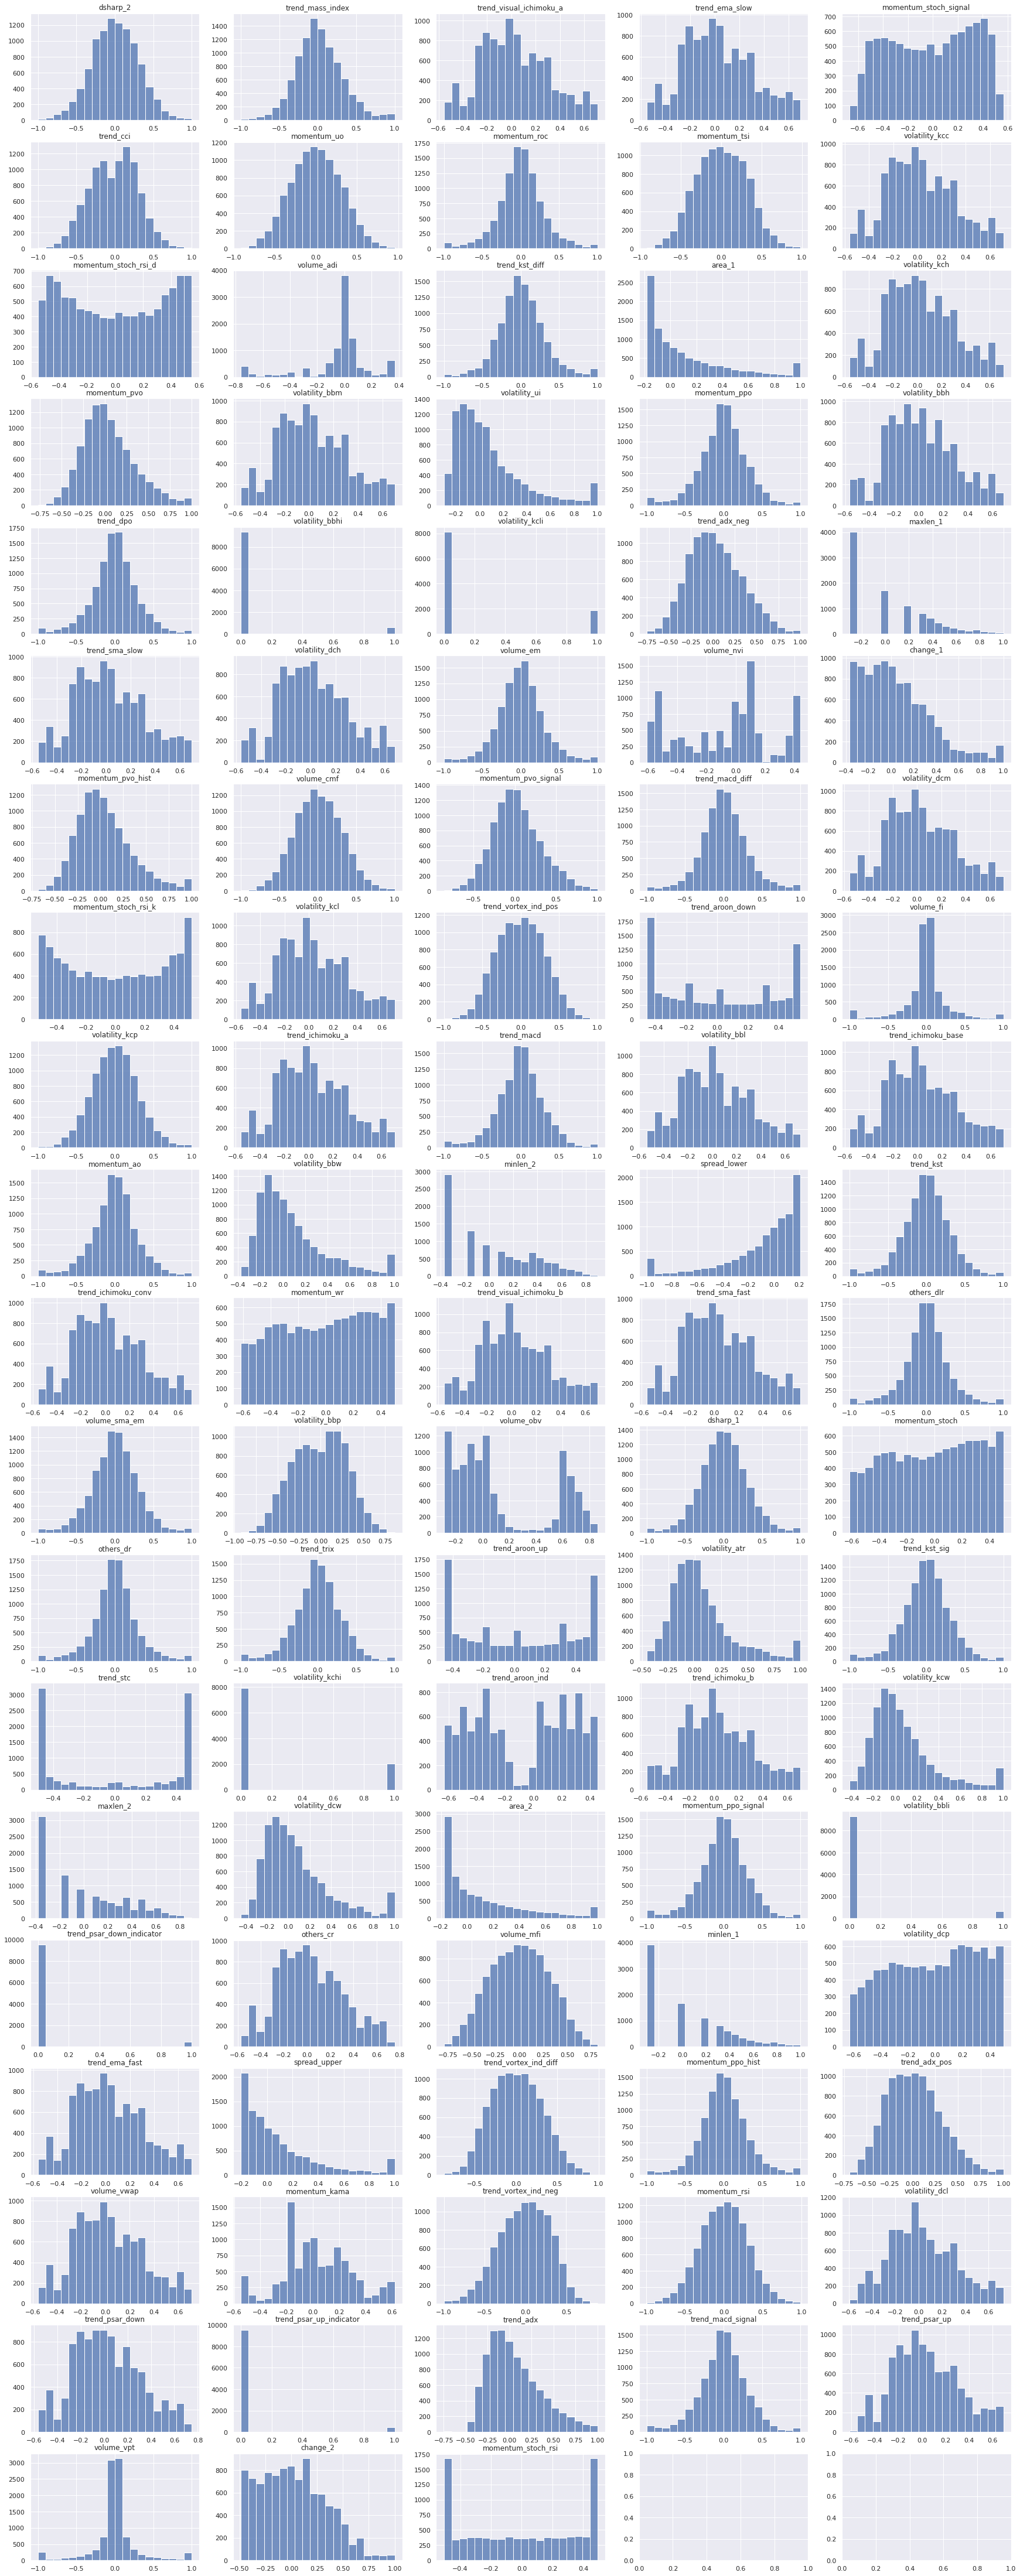

CPU times: user 6.82 s, sys: 71.1 ms, total: 6.89 s
Wall time: 6.71 s


In [84]:
%%time

uni_f = [f for f in features if not re.match(r"^.*_lag[1-9]*$", f)]

ncol = 5
nrow = math.ceil(a / ncol)

fig, axes = plt.subplots(nrow, ncol, figsize=(6 * ncol, 4 * nrow))
axes = axes.flatten()

for f, ax in zip(uni_f, axes):
    sns.histplot(train[f].values, ax=ax, bins=20)
    ax.set_ylabel("")
    ax.set_title(f)
plt.show()

In [90]:
import feather
feather.read_dataframe(cachedir / "df/ppo_df_5min.feather")

,timestamp,price,max_price,min_price,volume,buy_price,sell_price,price_1,spread_upper,spread_lower,...,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,fold
0,1609432500,28563,28705,28517,15921890,28705,28517,28686.0,0.824870,-0.142203,...,0.127417,-0.201921,-0.334666,-0.415312,0.013683,-0.348353,-0.570281,-0.571512,-0.348637,0.0
1,1609432800,28508,28600,28471,13306180,28600,28471,28563.0,0.471827,-0.079398,...,0.103042,-0.315930,-0.310681,-0.414545,0.058265,-0.348361,-0.256102,-0.256351,-0.350019,0.0
2,1609433100,28446,28572,28423,27689909,28572,28423,28508.0,0.715166,0.018916,...,0.070104,-0.427949,-0.162455,-0.377013,0.283557,-0.348374,-0.289254,-0.289571,-0.351576,0.0
3,1609433400,28430,28449,28328,22945221,28449,28328,28446.0,-0.046080,-0.539470,...,0.032280,-0.491876,-0.087039,-0.328204,0.352662,-0.348389,-0.074809,-0.074830,-0.351978,0.0
4,1609433700,28405,28434,28358,7833137,28434,28358,28430.0,0.025293,-0.151076,...,-0.008385,-0.529040,-0.146179,-0.303887,0.202579,-0.348407,-0.116954,-0.117007,-0.352606,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163970,1658623500,22541,22556,22530,973987,22556,22530,22548.0,-0.046658,0.083320,...,0.265458,-0.088419,-0.211989,-0.032240,-0.339136,-0.497196,-0.041290,-0.041297,-0.499887,4.0
163971,1658623800,22542,22551,22532,139480,22551,22532,22541.0,-0.100536,0.092237,...,0.256074,-0.119798,-0.317279,-0.109730,-0.421297,-0.497203,0.005900,0.005900,-0.499862,4.0
163972,1658624100,22537,22551,22537,735990,22551,22537,22542.0,-0.055615,0.181366,...,0.244663,-0.146315,-0.362671,-0.183028,-0.395606,-0.497212,-0.029501,-0.029504,-0.499987,4.0
163973,1658624400,22566,22579,22537,733567,22579,22537,22537.0,-0.064745,-0.076834,...,0.234465,-0.130456,-0.400149,-0.251000,-0.362973,-0.497217,0.171142,0.171033,-0.499259,4.0
